In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

### set pandas to reveal rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import math

### Load data

In [2]:
data_dir = '../data/raw'
os.listdir(data_dir)

['starter-notebook - Labs 1.ipynb',
 'test.csv',
 'sample.csv',
 'train.csv',
 'High_value_customers.csv',
 'data_dictionary.csv']

In [3]:
# load train
train = pd.read_csv(f'{data_dir}/train.csv')
test = pd.read_csv(f'{data_dir}/test.csv')
print(f'Samples in train dataset: {len(train)}')
print(f'Samples in test dataset : {len(test)}')

Samples in train dataset: 69999
Samples in test dataset : 30000


#### Investage target variable: Churn Probability

In [4]:
round(train['churn_probability'].value_counts() / len(train) * 100, 2).to_dict()

{0: 89.81, 1: 10.19}

Only 10% of samples in the train dataset churned to different telecom service provider.

#### Combine train and test samples to understand the independent variables

In [5]:
# set a placeholder value for churn probability in the test dataset to differiate with train
test['churn_probability'] = -1
df = pd.concat([train, test], axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 29999
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 132.0+ MB


#### Missing values

In [6]:
missing_df = pd.DataFrame(df.isna().sum(axis = 0).sort_values() / len(df)).reset_index()
missing_df.columns = ['feature', 'missing_proportion']
missing_df['missing_proportion'] = round(missing_df['missing_proportion'], 4)
missing_df

,feature,missing_proportion
0,id,0.0000
1,last_day_rch_amt_8,0.0000
2,last_day_rch_amt_7,0.0000
3,last_day_rch_amt_6,0.0000
4,max_rech_amt_8,0.0000
5,max_rech_amt_7,0.0000
6,max_rech_amt_6,0.0000
7,total_rech_amt_8,0.0000
8,total_rech_amt_7,0.0000
9,total_rech_amt_6,0.0000


In [7]:
thresholds = [i*0.05 for i in range(21)]
for idx, th in enumerate(thresholds):
    
    if idx != 0:
        n_features = sum((missing_df['missing_proportion'] > thresholds[idx-1]) & (missing_df['missing_proportion'] <= th))
    else:
        n_features = sum(missing_df['missing_proportion'] == th)
    
    if n_features != 0:
        print(f'# of features with {int(th * 100)}% missing values: {n_features} - ({int(100 * n_features / len(missing_df))}%)')

# of features with 0% missing values: 47 - (27%)
# of features with 5% missing values: 66 - (38%)
# of features with 10% missing values: 29 - (16%)
# of features with 75% missing values: 30 - (17%)


### Bin features into numerical, categorical and date

In [8]:
ignore_cols = ['id', 'circle_id', 'churn_probability']
num_features = [c for c in df.select_dtypes(include = [float, int]).columns if c not in ignore_cols]
date_features = [c for c in df.columns if 'date' in c]
cat_features = [c for c in df.columns if c not in ignore_cols + date_features + num_features]

print(f'# of numerical features                 : {len(num_features)}')
print(f'# of date features                      : {len(date_features)}')
print(f'# of remaining categorical features     : {len(cat_features)}')

# of numerical features                 : 160
# of date features                      : 9
# of remaining categorical features     : 0


Investigate binary features and the corresponding frequencies to take a call on dropping from analysis

In [9]:
drop_num_features = []
for f in num_features:
    if df[f].nunique() <= 3:
        print(f'{f:20s} [missing: {round(df[f].isnull().sum() / len(df), 4)}]   :   ', df[f].value_counts().to_dict())
        drop_num_features.append(f)

loc_og_t2o_mou       [missing: 0.0102]   :    {0.0: 98981}
std_og_t2o_mou       [missing: 0.0102]   :    {0.0: 98981}
loc_ic_t2o_mou       [missing: 0.0102]   :    {0.0: 98981}
std_og_t2c_mou_6     [missing: 0.0394]   :    {0.0: 96062}
std_og_t2c_mou_7     [missing: 0.0386]   :    {0.0: 96140}
std_og_t2c_mou_8     [missing: 0.0538]   :    {0.0: 94621}
std_ic_t2o_mou_6     [missing: 0.0394]   :    {0.0: 96062}
std_ic_t2o_mou_7     [missing: 0.0386]   :    {0.0: 96140}
std_ic_t2o_mou_8     [missing: 0.0538]   :    {0.0: 94621}
night_pck_user_6     [missing: 0.7485]   :    {0.0: 24522, 1.0: 631}
night_pck_user_7     [missing: 0.7443]   :    {0.0: 24982, 1.0: 589}
night_pck_user_8     [missing: 0.7366]   :    {0.0: 25790, 1.0: 549}
fb_user_6            [missing: 0.7485]   :    {1.0: 23000, 0.0: 2153}
fb_user_7            [missing: 0.7443]   :    {1.0: 23238, 0.0: 2333}
fb_user_8            [missing: 0.7366]   :    {1.0: 23463, 0.0: 2876}


I am dropping all the above features because they do not have much variance.

In [10]:
df.drop(columns = drop_num_features, inplace = True)
num_features = [f for f in num_features if f not in drop_num_features]
len(num_features)

145

### Impute missing value for numerical features

In [11]:
# Impute numerical features for those missing with <5% using Sklearn's KNN imputer
no_missing_num_features = []
fewer_missing_num_features = []
large_missing_num_features = []
for f, prop_missing in (df[num_features].isnull().sum() / len(df)).to_dict().items():
    if prop_missing == 0:
        no_missing_num_features.append(f)
    elif prop_missing <= 0.6:
        fewer_missing_num_features.append(f)
    else:
        large_missing_num_features.append(f)
print('Numerical features with no missing values                :', len(no_missing_num_features))
print('Numerical features with missing less than 6% of values   :', len(fewer_missing_num_features))
print('Numerical features with missing more than 6% of values   :', len(large_missing_num_features))

Numerical features with no missing values                : 43
Numerical features with missing less than 6% of values   : 81
Numerical features with missing more than 6% of values   : 21


In [12]:
# impute with knnimputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
df[fewer_missing_num_features] = imputer.fit_transform(df[fewer_missing_num_features])

In [13]:
## Features with missing values more than 6%
missing_df.loc[missing_df['feature'].isin(large_missing_num_features), :]

,feature,missing_proportion
144,total_rech_data_8,0.7366
145,max_rech_data_8,0.7366
146,count_rech_3g_8,0.7366
148,count_rech_2g_8,0.7366
149,arpu_3g_8,0.7366
150,av_rech_amt_data_8,0.7366
151,arpu_2g_8,0.7366
152,arpu_3g_7,0.7443
154,arpu_2g_7,0.7443
155,count_rech_3g_7,0.7443


The above features can be understood that those missing values represents the consumer not opting for the service. It is safe to replace missing values with 0.

In [14]:
df[large_missing_num_features] = df[large_missing_num_features].fillna(0)

In [15]:
### Verify no missing values after imputation
df[num_features].isnull().sum().sum()

0

In [16]:
### Feature engineering with combining the above large missing features from aggregating across the months
cols = ['arpu_2g', 'arpu_3g', 'av_rech_amt_data', 'count_rech_2g', 'count_rech_3g', 'max_rech_data', 'total_rech_data']
for f in cols:
    df[f'agg_{f}'] = df[[f'{f}_{month_num}' for month_num in [6, 7, 8]]].sum(axis = 1)
    num_features.append(f'agg_{f}')
df.drop(columns = large_missing_num_features, inplace = True)
num_features = [f for f in num_features if f not in large_missing_num_features]
len(num_features)

131

#### Distributions in relation to churn probability
Limited to train dataset alone

In [17]:
data = df[df['churn_probability'] != -1]
print(data.shape)

(69999, 143)


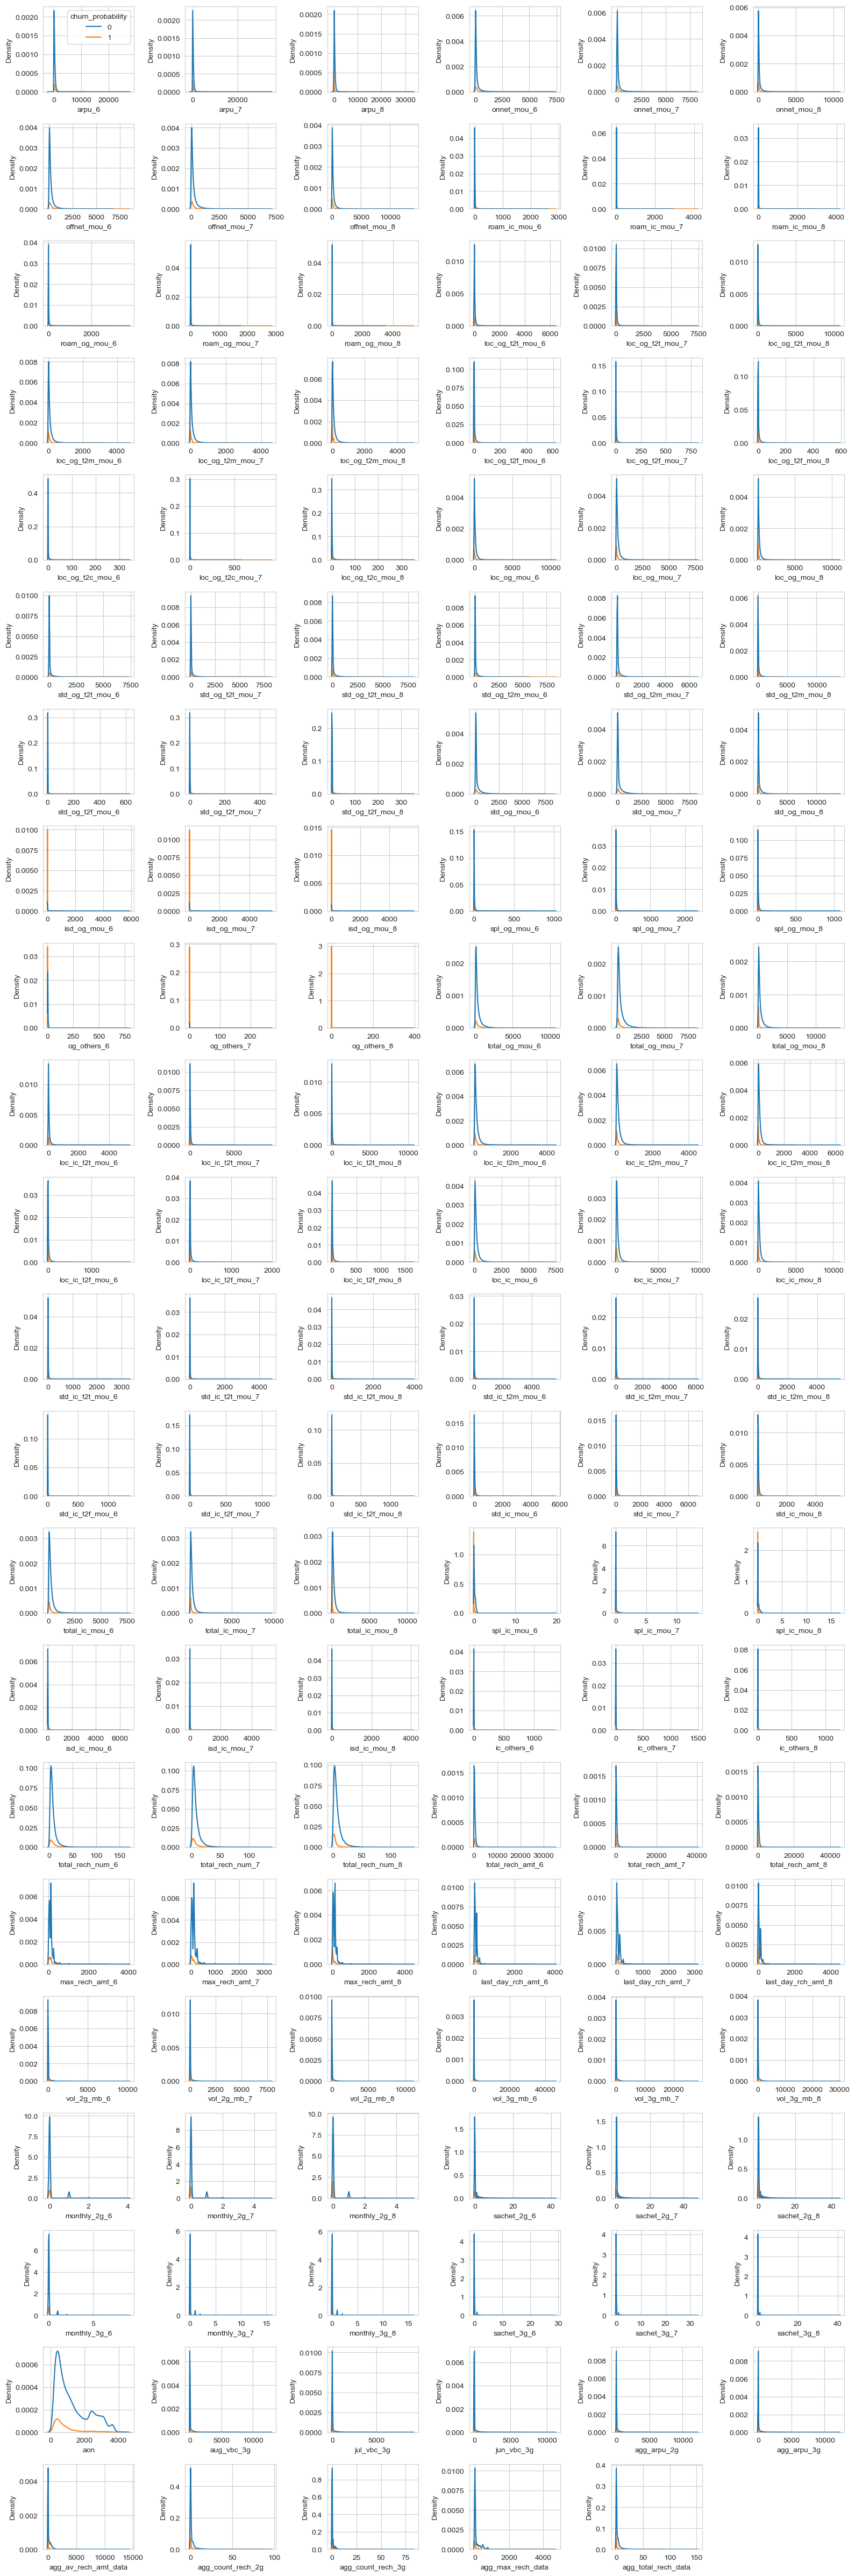

In [18]:
fig, axes = plt.subplots(math.ceil(131 / 6), 6, figsize = (16, 48))
for idx, ax in enumerate(axes.reshape(-1)):
    if idx < len(num_features):
        sns.kdeplot(data = data, x = num_features[idx], hue = 'churn_probability', ax = ax)
        if idx != 0:
            ax.get_legend().remove()
    else:
        ax.remove()
plt.tight_layout()
plt.show()

All the features are screwed because of outliers and it is best to scale them with interquantile range

In [19]:
## Clip outliers on the right side of the distribution to 97.5th percentile value
df[num_features] = df[num_features].apply(lambda x: x.clip(*x.quantile([0, 0.975])))

In [20]:
data = df.copy()

from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = RobustScaler()
data[num_features] = scaler.fit_transform(data[num_features].values)

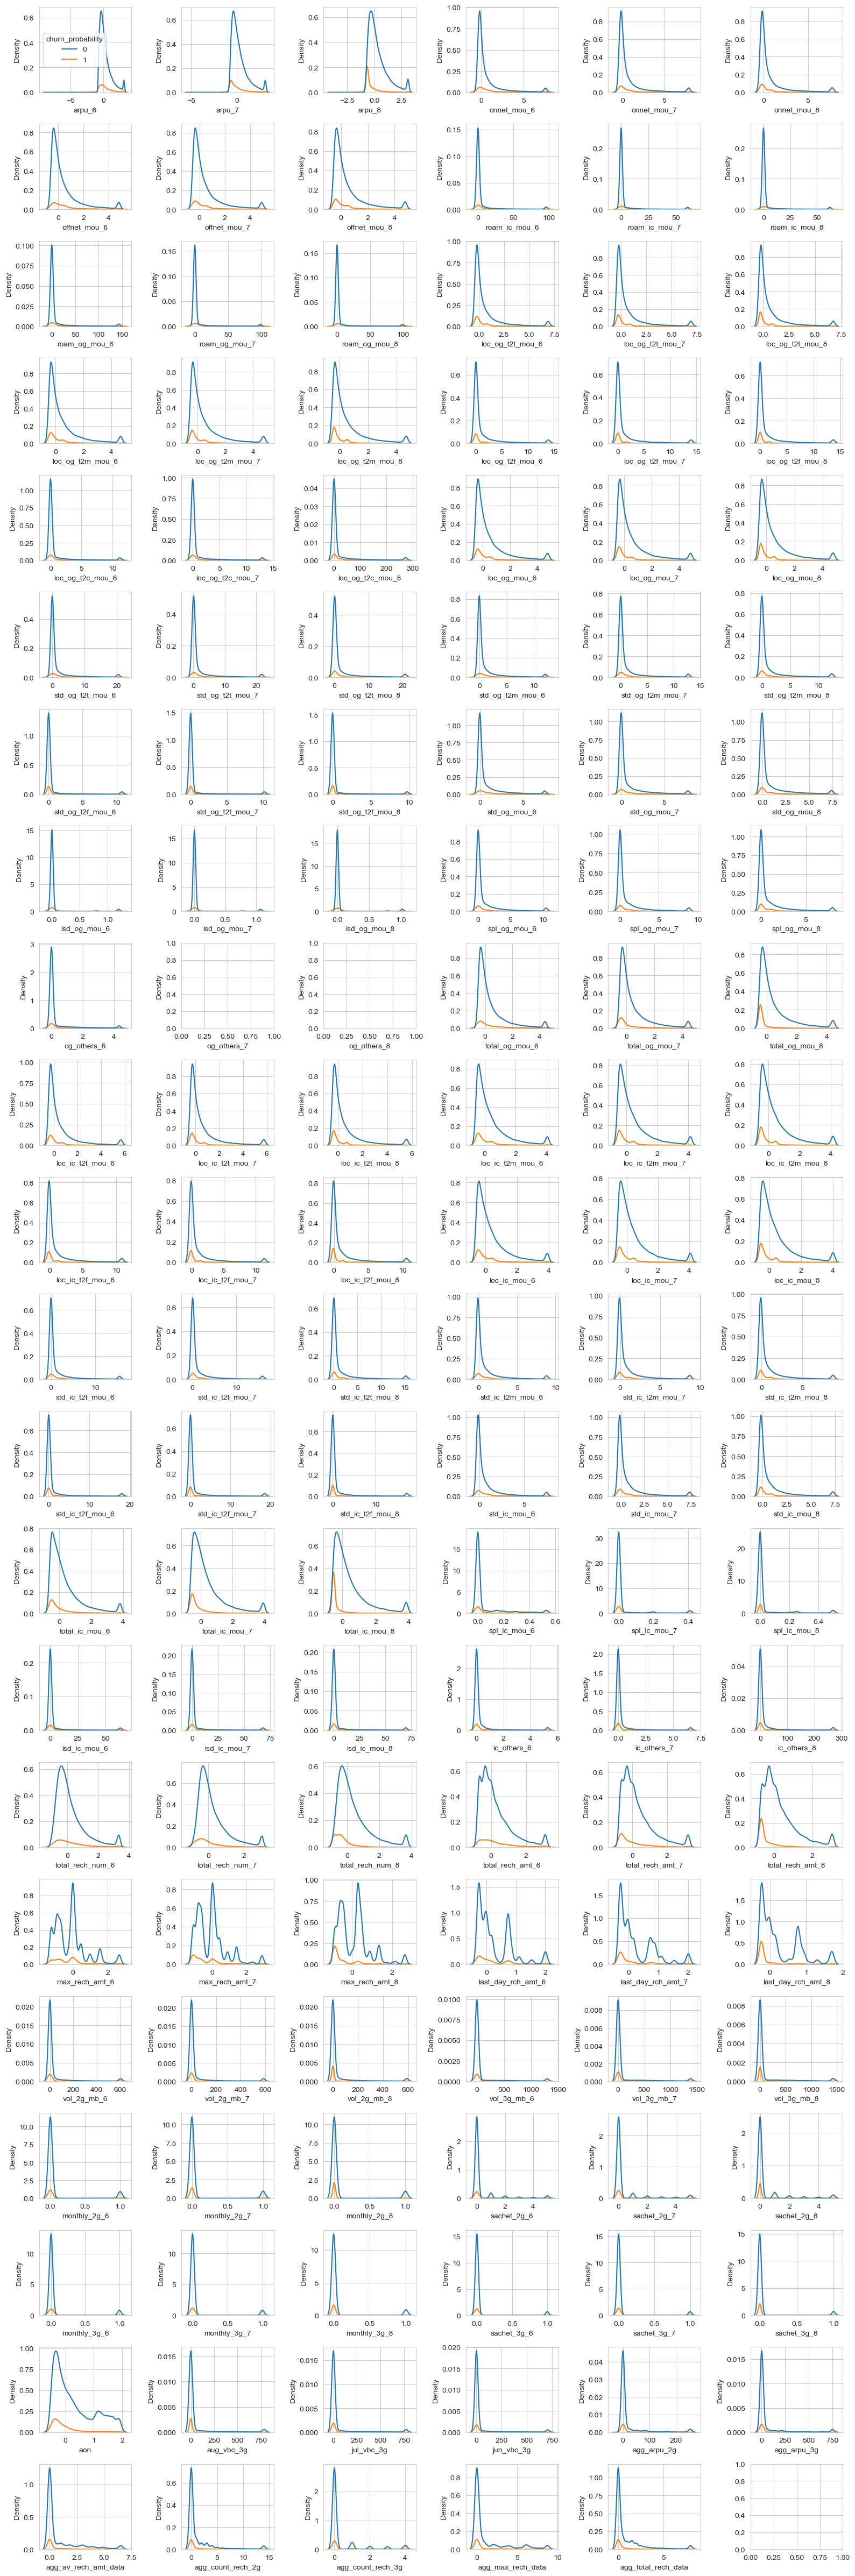

In [21]:
data = data[data['churn_probability'] != -1]
fig, axes = plt.subplots(math.ceil(131 / 6), 6, figsize = (16, 48))
for idx, ax in enumerate(axes.reshape(-1)):
    if idx < len(num_features):
        sns.kdeplot(data = data, x = num_features[idx], hue = 'churn_probability', ax = ax)
        if idx != 0:
            ax.get_legend().remove()
plt.tight_layout()
plt.show()

### Date features

In [22]:
for f in date_features:
    df[f] = pd.to_datetime(df[f], errors = 'ignore')

In [23]:
df[date_features].isna().sum()

last_date_of_month_6            0
last_date_of_month_7          601
last_date_of_month_8         1100
date_of_last_rech_6          1607
date_of_last_rech_7          1767
date_of_last_rech_8          3622
date_of_last_rech_data_6    74846
date_of_last_rech_data_7    74428
date_of_last_rech_data_8    73660
dtype: int64

In [24]:
d = df.copy()
d = d[d['churn_probability'] != -1]
for f in date_features:
    print(f'{f:30s}:', d[d[f].isna()]['churn_probability'].value_counts().to_dict())

last_date_of_month_6          : {}
last_date_of_month_7          : {1: 399}
last_date_of_month_8          : {1: 733}
date_of_last_rech_6           : {0: 821, 1: 280}
date_of_last_rech_7           : {1: 654, 0: 580}
date_of_last_rech_8           : {1: 1384, 0: 1077}
date_of_last_rech_data_6      : {0: 46810, 1: 5621}
date_of_last_rech_data_7      : {0: 46173, 1: 5961}
date_of_last_rech_data_8      : {0: 45070, 1: 6512}


- Consumer records with missing last dates for a selected month (7 & 8) churned from the telecom network
- Most of the consumer opted to not recharge are with the network

In [25]:
for f in ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']:
    print(f'{f:20s} :', list(df[f].unique()))

last_date_of_month_6 : [Timestamp('2014-06-30 00:00:00')]
last_date_of_month_7 : [Timestamp('2014-07-31 00:00:00'), NaT]
last_date_of_month_8 : [Timestamp('2014-08-31 00:00:00'), NaT]


Features derived on dates

In [26]:
## Did the consumer is with the network till the end of the month
df['is_last_date_of_month_present_6'] = 1 - (df['last_date_of_month_6'].isna() * 1)
df['is_last_date_of_month_present_7'] = 1 - (df['last_date_of_month_7'].isna() * 1)
df['is_last_date_of_month_present_8'] = 1 - (df['last_date_of_month_8'].isna() * 1)

num_features.extend(['is_last_date_of_month_present_6', 'is_last_date_of_month_present_7', 'is_last_date_of_month_present_8'])

## Days left in the month after recharge
## replace missing value with the max days in the month
for i in [6, 7, 8]:
    df[f'days_left_after_recharge_{i}']         = (df[f'last_date_of_month_{i}'] - df[f'date_of_last_rech_{i}']) / np.timedelta64(1, 'D')
    df[f'days_left_data_after_recharge_{i}']    = (df[f'last_date_of_month_{i}'] - df[f'date_of_last_rech_data_{i}']) / np.timedelta64(1, 'D')
    df[f'days_left_after_recharge_{i}']         = df[f'days_left_after_recharge_{i}'].fillna(df[f'last_date_of_month_{i}'].max().date().day)
    df[f'days_left_data_after_recharge_{i}']    = df[f'days_left_data_after_recharge_{i}'].fillna(df[f'last_date_of_month_{i}'].max().date().day)
    num_features.append(f'days_left_after_recharge_{i}')
    num_features.append(f'days_left_data_after_recharge_{i}')
    
df.drop(columns = date_features, inplace = True)

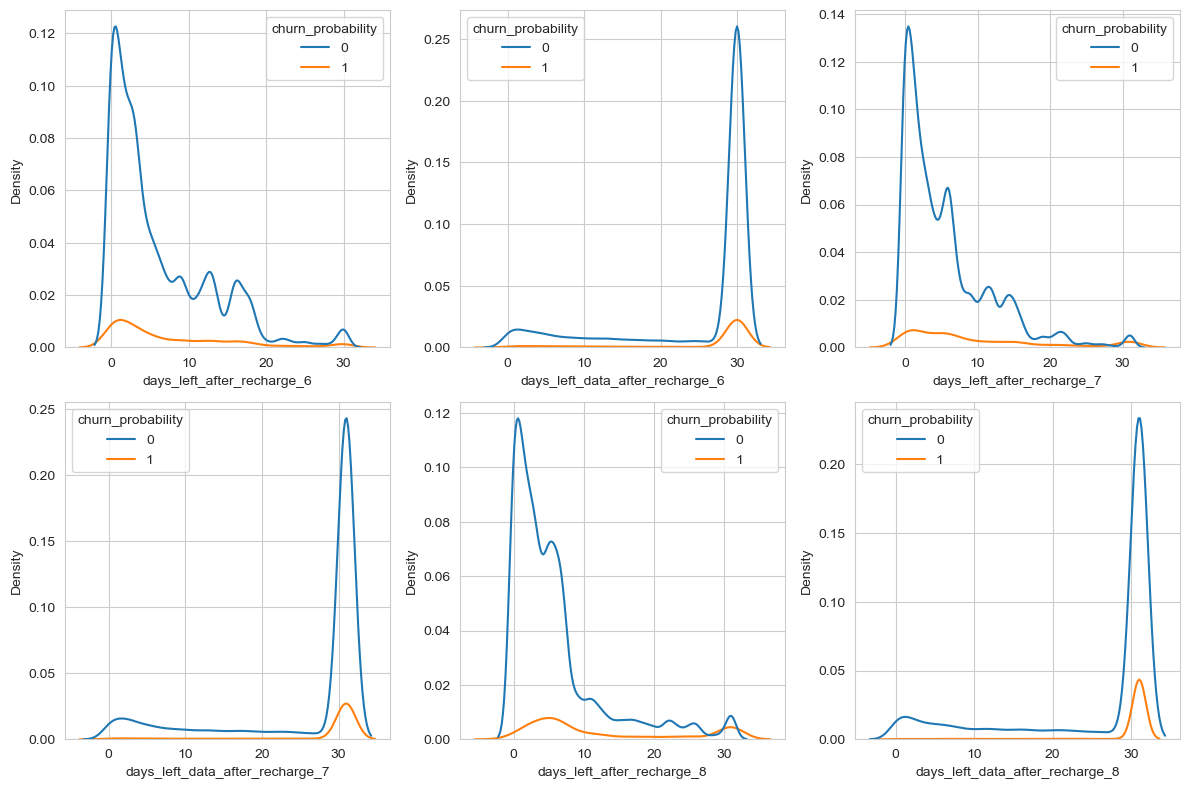

In [27]:
date_derived_features = []
for i in [6, 7, 8]:
    date_derived_features.extend([f'days_left_after_recharge_{i}', f'days_left_data_after_recharge_{i}'])

fig, axes = plt.subplots(2, 3, figsize = (12, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    sns.kdeplot(data = df[df['churn_probability'] != -1], x = date_derived_features[idx], hue = 'churn_probability', ax = ax)
plt.tight_layout()
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 29999
Columns: 143 entries, id to days_left_data_after_recharge_8
dtypes: float64(112), int64(31)
memory usage: 109.9 MB


#### Correlation between features

In [29]:
# ensure no missing values
df.isnull().sum().sum()

0

<Axes: >

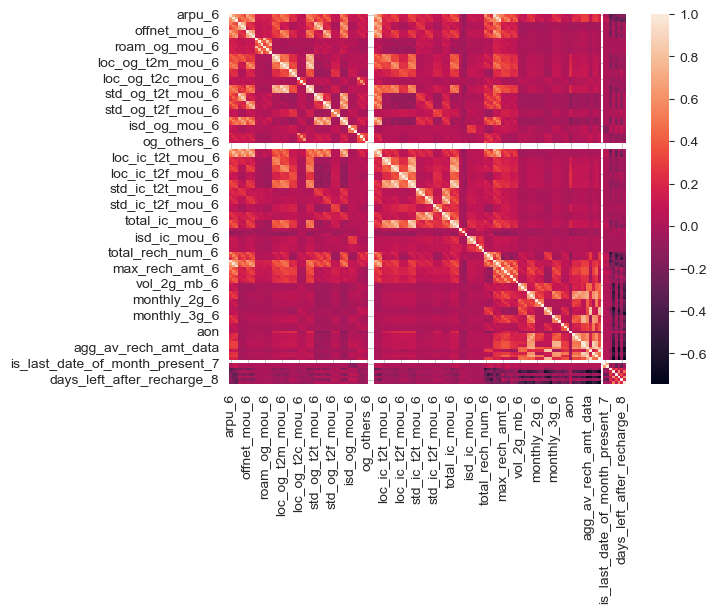

In [30]:
corr = df.drop(columns = ignore_cols).corr()
sns.heatmap(corr)

In [31]:
## Normalize numerical and features derived from dates
df[num_features + date_derived_features] = StandardScaler().fit_transform(df[num_features + date_derived_features])

### Create new column from defining new clusters

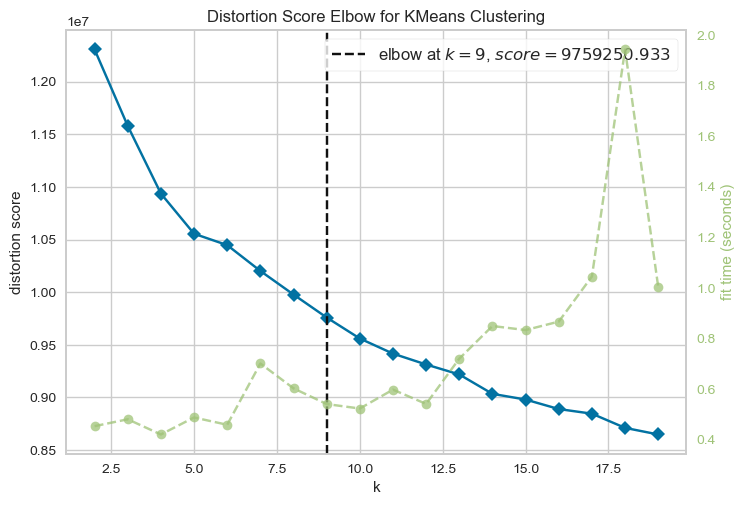

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,20))

visualizer.fit(df.drop(columns = ignore_cols))        # Fit the data to the visualizer
visualizer.show()

In [33]:
km = KMeans(n_clusters=9,
            init='k-means++',
            n_init=10,
            max_iter=500,
            random_state=42)

clusters = km.fit_predict(df.drop(columns = ignore_cols))
df['clusters'] = clusters / km.n_clusters

In [34]:
## Save in the data/processed directory
## Save
train = df[df['churn_probability'] != -1]
test = df[df['churn_probability'] == -1]

train.to_csv('../data/processed/scaled_train.csv', index = False)
test.to_csv('../data/processed/scaled_test.csv', index = False)

train.shape, test.shape

((69999, 144), (30000, 144))

In [35]:
df.head(10)

,id,circle_id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,agg_arpu_2g,agg_arpu_3g,agg_av_rech_amt_data,agg_count_rech_2g,agg_count_rech_3g,agg_max_rech_data,agg_total_rech_data,is_last_date_of_month_present_6,is_last_date_of_month_present_7,is_last_date_of_month_present_8,days_left_after_recharge_6,days_left_data_after_recharge_6,days_left_after_recharge_7,days_left_data_after_recharge_7,days_left_after_recharge_8,days_left_data_after_recharge_8,clusters
0,0,109,-0.964819,-0.718095,-1.023077,-0.344220,0.034074,-0.571037,-0.659915,-0.362328,-0.780389,-0.308655,-0.287810,-0.289654,-0.324759,-0.298287,-0.295153,-0.562155,-0.596671,-0.599290,-0.703915,-0.602645,-0.731565,-0.442942,-0.442141,-0.444215,-0.349480,-0.357968,-0.369723,-0.715732,-0.660300,-0.743669,-0.130552,0.325509,-0.409559,-0.349115,0.028124,-0.465694,-0.275955,-0.272035,-0.274814,-0.305325,0.160221,-0.527324,-0.228763,-0.225838,-0.226605,0.771941,-0.417839,-0.514689,0.039602,0.0,0.0,-0.559718,-0.182642,-0.754854,-0.621174,-0.599855,-0.536137,-0.831998,-0.660571,-0.701413,-0.480459,-0.474141,-0.484550,-0.848827,-0.725428,-0.733646,-0.429948,0.064370,-0.417429,-0.266502,0.125351,-0.029783,-0.320925,-0.321597,-0.328422,-0.393564,0.024505,-0.231798,-0.822862,-0.632328,-0.683581,-0.444693,-0.312267,4.254512,-0.284514,-0.293681,-0.294707,0.808327,0.247768,-0.319621,-0.744397,-0.928591,-0.823298,-0.791209,-0.806377,-0.984861,-0.401869,-0.387689,-1.017683,0.105122,0.158024,-0.811139,-0.321784,-0.322488,-0.318661,-0.325920,-0.331562,-0.338347,-0.281141,-0.286060,-0.282856,-0.316006,-0.325380,-0.333714,-0.246064,-0.245240,-0.254122,-0.208889,-0.207556,-0.209124,0.788535,-0.32529,-0.317716,-0.310181,0,-0.365766,-0.340875,-0.539848,-0.441708,-0.376734,-0.529199,-0.503563,0.0,0.077759,0.105463,0.252879,0.514823,2.265027,0.520187,0.068636,0.528254,0.555556
1,1,109,-1.090660,-0.574820,-0.883165,-0.586254,-0.570650,-0.577410,-0.800946,-0.668071,-0.655358,-0.308655,-0.287810,-0.289654,-0.324759,-0.298287,-0.295153,-0.598815,-0.596671,-0.604070,-0.751144,-0.747769,-0.752754,-0.442942,-0.442141,-0.444215,-0.349480,4.473005,4.452183,-0.759956,-0.755526,-0.759277,-0.415195,-0.411908,-0.415572,-0.466977,-0.460394,-0.465694,-0.275955,-0.272035,-0.274814,-0.530225,-0.5

### Identify pattern in the dataset with PCA dimensionality reduction method 
Create a complementary dataset for modeling in the downstream

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=70)
components = pca.fit_transform(np.transpose(df.drop(columns = ignore_cols)))
print(sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

0.9337339633008964


array([0.10120222, 0.09192536, 0.07338318, 0.04835966, 0.04048114,
       0.03070173, 0.02797281, 0.02740912, 0.0254781 , 0.02372765,
       0.02230645, 0.02038729, 0.01832187, 0.01770353, 0.01578012,
       0.01475476, 0.01400105, 0.01334436, 0.01268003, 0.01242414,
       0.01182982, 0.01128132, 0.01077507, 0.00975756, 0.00930847,
       0.00908774, 0.00883593, 0.0084657 , 0.00817862, 0.00798263,
       0.00783461, 0.00725514, 0.00700184, 0.006839  , 0.00650597,
       0.00641597, 0.00635721, 0.00612561, 0.00579418, 0.00556094,
       0.00545593, 0.00540617, 0.00526675, 0.00519912, 0.00513935,
       0.00506261, 0.00485839, 0.00473924, 0.00466886, 0.00453296,
       0.00437987, 0.00428801, 0.0042198 , 0.00409859, 0.00403859,
       0.00399195, 0.00395176, 0.00391463, 0.00370152, 0.0035774 ,
       0.00351712, 0.00347574, 0.00323141, 0.00305884, 0.00299458,
       0.00288654, 0.00270111, 0.00266974, 0.00260992, 0.00255954])

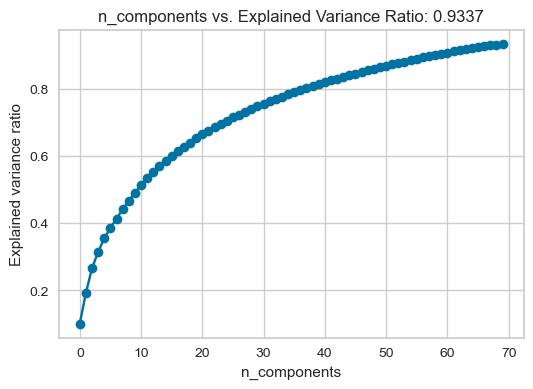

In [37]:
plt.figure(figsize=(6,4),dpi=100)
plt.grid()
plt.plot(range(pca.n_components), np.cumsum(pca.explained_variance_ratio_), marker = 'o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title(f'n_components vs. Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.4f}')
plt.show()

In [38]:
df[ignore_cols].head(10)

,id,circle_id,churn_probability
0,0,109,0
1,1,109,0
2,2,109,0
3,3,109,0
4,4,109,0
5,5,109,0
6,6,109,0
7,7,109,0
8,8,109,1
9,9,109,0


In [39]:
pca_df = pd.concat([df[ignore_cols].reset_index(drop = True), 
                    pd.DataFrame(np.transpose(pca.components_), columns = [f'component_{i}' for i in range(pca.n_components)])], 
                   axis = 1)
pca_df.shape

(99999, 73)

In [40]:
## Save
pca_train = pca_df[pca_df['churn_probability'] != -1]
pca_test = pca_df[pca_df['churn_probability'] == -1]

pca_train.to_csv('../data/processed/pca_train.csv', index = False)
pca_test.to_csv('../data/processed/pca_test.csv', index = False)

pca_train.shape, pca_test.shape

((69999, 73), (30000, 73))

##### Visualize PCA

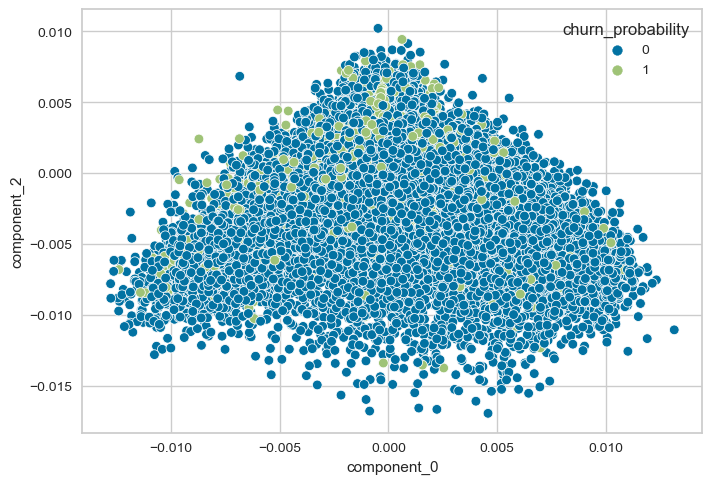

In [41]:
sns.scatterplot(data = pca_df[pca_df['churn_probability'] != -1], 
                x = 'component_0', 
                y = 'component_2', 
                hue = 'churn_probability')
plt.show()

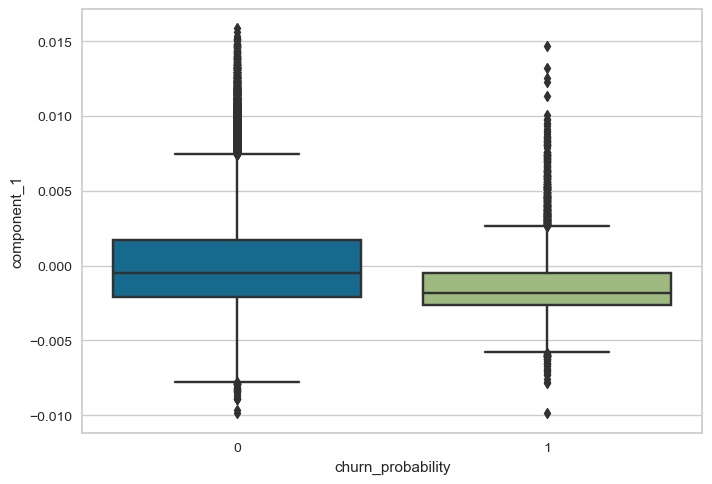

In [42]:
sns.boxplot(data = pca_df[pca_df['churn_probability'] != -1], 
            x = 'churn_probability', 
            y = 'component_1')
plt.show()

Compress PCA components into 2 with TSNE for better visualization

In [43]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(np.transpose(pca.components_))
X_embedded.shape

(99999, 2)

In [44]:
tsne_df = pd.DataFrame({'tsne_1' : X_embedded[:, 0],
                        'tsne_2' : X_embedded[:, 1],
                        'churn_probability': df['churn_probability'],})
print(tsne_df.shape)

(99999, 3)


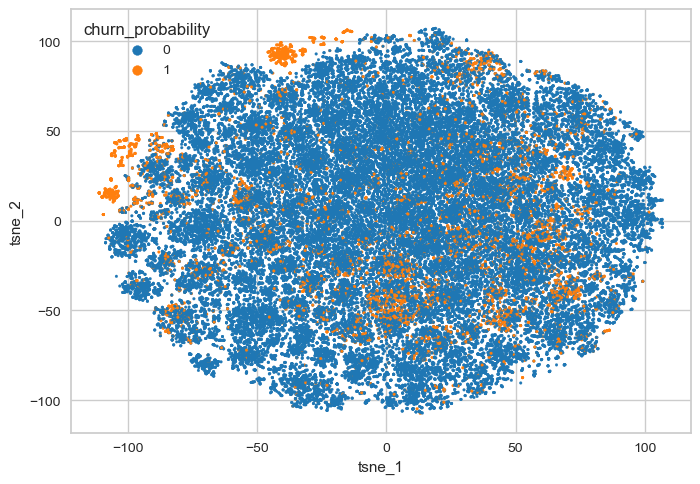

In [45]:
sns.scatterplot(data = tsne_df[tsne_df['churn_probability'] != -1], 
                x = 'tsne_1', 
                y = 'tsne_2', 
                hue = 'churn_probability',
                palette = 'tab10', 
                s = 4, 
                edgecolor = None)
plt.show()

### END